# Optimization for Data Science 2024 Homework 1

**Students:**

*Alberto Calabrese* - Student ID: 2103405

*Greta d'Amore Grelli* - Student ID: 2122424

*Eleonora Mesaglio* - Student ID: 2103402

*Marlon Helbing* - Student ID: 2106578

Let us consider $m$ samples described by $d$ features and divided in $k$ classes. We want to solve the multi-class classification problem of the form:

$$
\min_{X\in\R^{d\times k}} f(x) = \min_{X\in\R^{d\times k}} \sum_{i=1}^{m}\left[-x_{b_i}^Ta_i + \log\left(\sum_{c=1}^{k}\exp(x_c^Ta_i)\right)\right],
$$

where $a_i\in\R^d$ are the features of the $i$-th sample, $x_c\in\R^d$ is the column vector of the matrix of parameters $X\in\R^{d\times k}$ relating to class $c$ and $b_i\in\{1,\dots k\}$ is the label associated to the $i$-th sample, given by the following probability:

$$
P(b_i | X, a_i) = \frac{\exp(x_{b_i}^Ta_i)}{\sum_{c=1}^{k}\exp(x_c^Ta_i)}.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Set a seed for deterministic outputs
SEED = 42
np.random.seed(seed = SEED)

In [2]:
def plotting_GD(times,losses,gradient_norms):
    # Plotting loss vs time
    plt.figure(figsize=(10, 6))
    plt.plot(times, losses)
    plt.xlabel('CPU time (seconds)')
    plt.ylabel('Objective function')
    plt.title('Objective function vs CPU time - Gradient Descent')
    plt.show()

    # Plotting gradient norm across iterations
    plt.figure(figsize=(10, 6))
    plt.plot(gradient_norms, label = 'Gradient Norm')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm across Iterations - Gradient Descent')
    plt.show()

def plotting_RAND(times,losses,gradient_norms):
    # Plotting loss vs time
    plt.figure(figsize=(10, 6))
    plt.plot(times, losses)
    plt.xlabel('CPU time (seconds)')
    plt.ylabel('Objective function')
    plt.title('Objective function vs CPU time - BCGD Randomized')
    plt.show()

    # Plotting gradient norm across iterations
    plt.figure(figsize=(10, 6))
    plt.plot(gradient_norms, label = 'Gradient Norm')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm across Iterations - BCGD Randomized')
    plt.show()

def plotting_GS(times,losses,gradient_norms):
    # Plotting loss vs time
    plt.figure(figsize=(10, 6))
    plt.plot(times, losses)
    plt.xlabel('CPU time (seconds)')
    plt.ylabel('Objective function')
    plt.title('Objective function vs CPU time - BCGD Gauss-Southwell')
    plt.show()

    # Plotting gradient norm across iterations
    plt.figure(figsize=(10, 6))
    plt.plot(gradient_norms, label = 'Gradient Norm')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm across Iterations - BCGD Gauss-Southwell')
    plt.show()

## 1. Generating the dataset

We randomly generate the matrices $A\in\R^{m\times d}$ of the features, $X\in\R^{d\times k}$ of the parameters and $E\in\R^{m\times k}$, with entries from normal distribution.

In [3]:
NUM_SAMPLES = 1000
NUM_FEATURES = 1000
NUM_LABELS = 50
NUM_EXAMPLES = 1000

# A MATRIX
# Generate a 1000x1000 matrix with random samples from a standard normal distribution
# This is our data matrix, which contains 1000 samples (rows) with 1000 features each (columns)
data_matrix = np.random.normal(0, 1, size = (NUM_SAMPLES, NUM_FEATURES))
A = data_matrix 
# 'A' contains random values drawn from N(0,1)
print("A shape: ", A.shape)

# X MATRIX
# This is our weight matrix that we initialize like this ; these weights we want to learn
# it has 1000 features (rows) with 50 labels each (columns)
weight_matrix = np.random.normal(0, 1, size = (NUM_FEATURES, NUM_LABELS))
X = weight_matrix
# 'X' contains random values drawn from N(0,1)
print("X shape: ", X.shape)

# E MATRIX
# This matrix is used to help generating our supervised gold labels 
# It is of size 1000 training examples (rows) and their labels (columns)
# It acts like a sort of bias matrix
generative_matrix = np.random.normal(0, 1, size = (NUM_EXAMPLES, NUM_LABELS))
E = generative_matrix
# 'E' contains random values drawn from N(0,1)
print("E shape: ", E.shape)

# LABEL VECTOR
# Create a vector with numbers from 1 to 50
label_vector = np.arange(1, 51)

# Now calculate AX+E to generate labels for the 1000 training examples (such that we have a supervised learning set) 

result_matrix = A @ X + E

print("AX+E shape: ", result_matrix.shape)

A shape:  (1000, 1000)
X shape:  (1000, 50)
E shape:  (1000, 50)
AX+E shape:  (1000, 50)


## 2. Generating the labels

The labels $b_i$ of the $i$-th sample are chosen by considering $i$-th row of the following matrix $$B = AX + E$$ and taking as $b_i$ the column index with maximum value. 

We generate those labels by creating the vector $labels\in\R^{m}$ that in position $i$ has the label $b_i$ of the $i$-th sample.

Note that our labels are such that $labels\in\{0,\dots,k-1\}$.

In [4]:
labels = np.argmax(result_matrix, axis=1)
print("Labels shape: ", labels.shape)

Labels shape:  (1000,)


In [5]:
m = NUM_SAMPLES # samples
d = NUM_FEATURES # features
k = NUM_LABELS   # labels

## 3. Cost function 



In order to construct an efficient algorithm, it is useful to re-write the functions we need to implement in a more compact way.

Our cost function has the following form:
$$
    f = \left(-\text{diag}\left((AX)^T\cdot I_b\right) + \log\left(\exp(AX)\cdot \mathbf{1}_k\right)\right)^T\cdot\mathbf{1}_m.
$$



In [6]:
# Matrix for the encoding of all classes
I = np.zeros((m,k))
for label_idx in range(k):

    I[:,label_idx] = np.eye(k)[labels][:, label_idx]

# Indicator matrix for classes of samples (Transpose of I)
I_b = I.T

In [7]:
def cost_function(X,A,labels):

    term_1 = -1 * (np.diag((A @ X) @ I_b))
    
    term_2 = np.exp(A @ X) @ np.ones((k,1))

    final = (term_1 + (np.log(term_2)).flatten()) @ np.ones((m,1))

    return final  

## 4. Lipschitz

In [8]:
def lipschitz(A):
    L = np.linalg.norm(A,2) * np.linalg.norm(A, 'fro')
    return L

## 5. Hyperparameters

In [9]:
EPSILON = 1e-6
ITERATIONS = 3000
LR = 1/lipschitz(A)

## 6. Full Gradient


In [10]:
def full_gradient(X,A,labels):

    return (-1 * A.T) @ (I - ((np.exp(A @ X)) / (np.exp(A @ X) @ np.ones((k,1)))))

## 7. Partial Gradient

In [11]:
def partial_gradient(X,A,labels,c):

    return (-1 * A.T) @ (I[:,c] - (np.exp(A @ X[:, c]) / ((np.exp(A @ X) @ np.ones((k,1))).flatten())))

## 8. Gradient Descent Algorithm

In [12]:
def gradient_descent(X,A,labels,lr, iterations):

    gradient_norms = []
    X_values = []
    times = []
    start_time = time.time()

    for i in range(iterations):

        # Keep track of X values 

        X_values.append(X)

        # Calculate gradient

        grad = full_gradient(X,A,labels)

        # Get the gradient norm

        norm = np.linalg.norm(grad)

        # Check the norm stopping criterium

        if norm < EPSILON:
            break

        # Keep track of gradient norms 

        gradient_norms.append(norm)

        # Gradient step

        X = X - lr * grad

        # Keep track of the time
        
        times.append(time.time() - start_time)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

    return X_values, gradient_norms, times

Execution time: 23.233431100845337 seconds


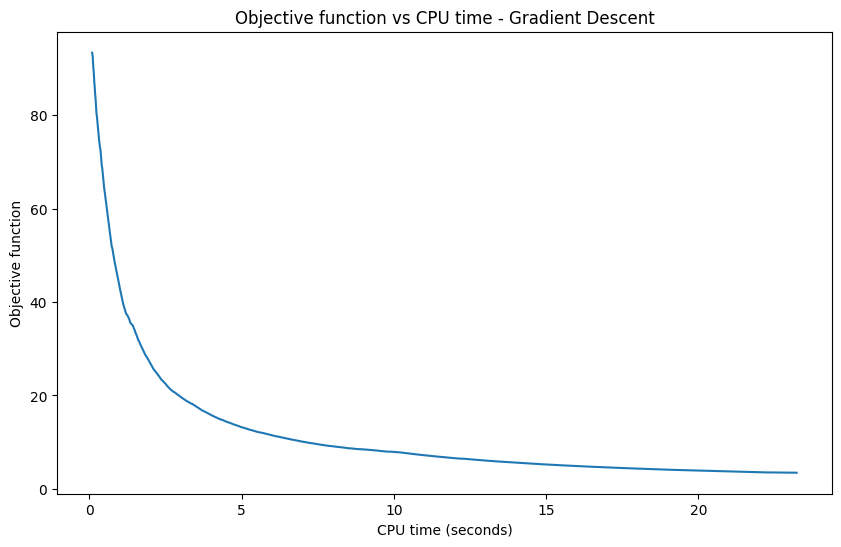

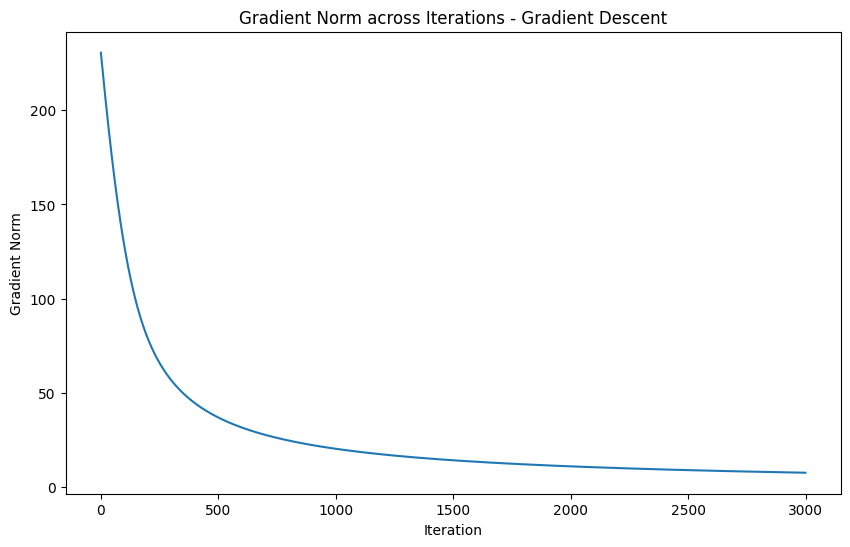

In [13]:
X_values, gradient_norms_GD, times_GD = gradient_descent(X,A,labels, lr= LR, iterations= ITERATIONS)

losses_GD = [cost_function(X_val, A, labels) for X_val in X_values]

plotting_GD(times_GD,losses_GD,gradient_norms_GD)

## 9. BCGD Randomized Rule

In [14]:
# Generate the list of random choices of classes beforehand (For better efficiency)
random_choices = []
for i in range(ITERATIONS):
    random_choices.append(random.randint(0,k-1)) 

In [15]:
def BCGD_randomized(X,A,labels,lr, iterations):

    # Use a copy of X so we can run the algorithm multiple times on the original X
    X_copy = X.copy()

    gradient_norms = []
    X_values = []
    times = []
    start_time = time.time()

    # Calculate the full gradient once
    grad = full_gradient(X_copy,A,labels)

    for i in range(iterations): 
        # Keep track of X values 
        X_values.append(np.copy(X_copy))

        # Get the randomly generated block
        curr_c = random_choices[i] 
        
        # Take the random block
        curr_grad = grad[:, curr_c]
        
        # Recalculate the gradient of the random block
        grad[:, curr_c] = partial_gradient(X_copy,A,labels,curr_c) 
      
        # Calculate the gradient norm
        norm = np.linalg.norm(grad)

        # Check the stopping criterium
        if norm < EPSILON:
            break

        # Keep track of the gradient norm
        gradient_norms.append(norm)

        # Gradient step
        X_copy = X_copy - lr * grad

        # Keep track of the time
        times.append(time.time() - start_time)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

    return X_values, gradient_norms, times

Execution time: 16.274691820144653 seconds


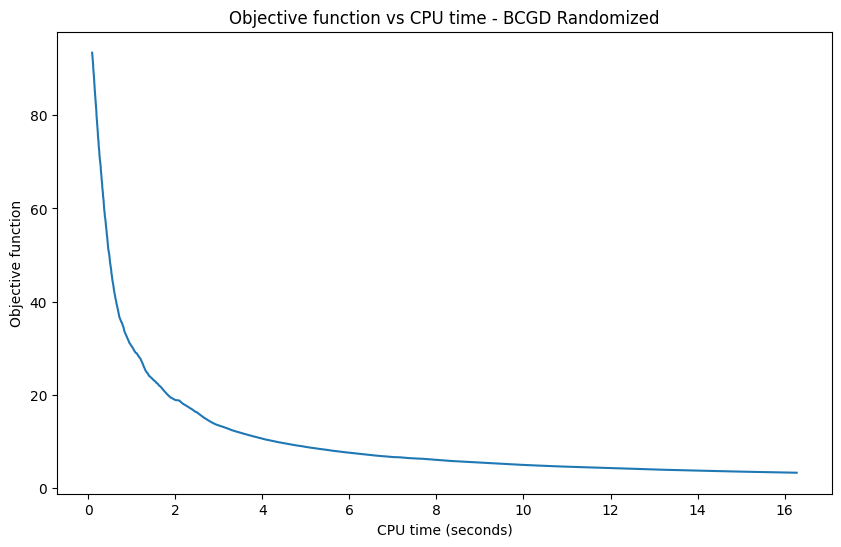

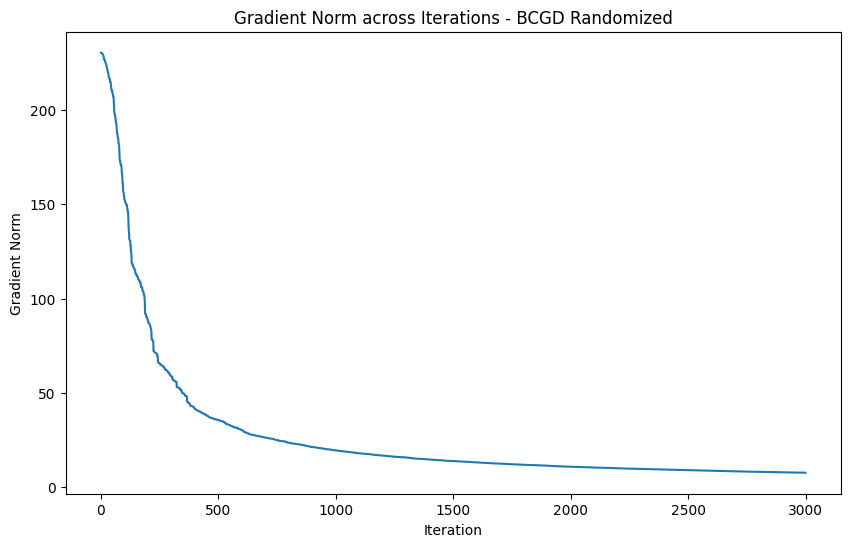

In [16]:
X_values, gradient_norms_BCGD, times_BCGD = BCGD_randomized(X,A,labels, lr = LR, iterations= ITERATIONS)

losses_BCGD = [cost_function(X_val, A, labels) for X_val in X_values]

plotting_RAND(times_BCGD, losses_BCGD, gradient_norms_BCGD)

## 10. BCGD Gauss-Southwell Algorithm

In [17]:
def Gauss_Southwell_final(X,A, labels,lr, iterations):
    # Use a copy of X so we can run the algorithm multiple times on the original X
    X_copy = X.copy()

    gradient_norms = []
    X_values = []
    times = []
    start_time = time.time()

    # Calculate the full gradient once
    grad = full_gradient(X_copy,A,labels)

    # Calculate the gradient norm of each block
    norms = np.linalg.norm(grad, axis=0)

    # Initialize the max norm index variable
    max_norm_class_index = None

    for it in range(iterations): # iterations
        # In each iteration, check if there is a new maximal norm : Choose the biggest one for updating

        # Keep track of X values 
        X_values.append(np.copy(X_copy))
        
        # In the first iteration, we already calculated gradients for all blocks, so we do the updating only starting
        # at the second iteration
        if it > 0:
            # Recalculate the gradient of the block gradient we updated
            grad[:, max_norm_class_index] = partial_gradient(X_copy,A,labels,c=max_norm_class_index)
            # Recalculate the norm of the block gradient we updated
            norms[max_norm_class_index] = np.linalg.norm(grad[:, max_norm_class_index])

        # Get sum of norms of each block
        sum_norms = np.sum(norms)

        # Check the stopping criterium
        if sum_norms < EPSILON:
            break

        # Get the index of the column with the largest norm in the current iteration
        max_norm_class_index = np.argmax(norms)
 
        # Select the column with the largest norm
        max_norm_partial_grad = grad[:, max_norm_class_index]

        # Keep track of the gradient norm
        gradient_norms.append(sum_norms) 
        
        # Gradient step
        X_copy = X_copy- lr * grad

        # Keep track of the time
        times.append(time.time() - start_time)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

    return X_values, gradient_norms, times

Execution time: 14.972437143325806 seconds


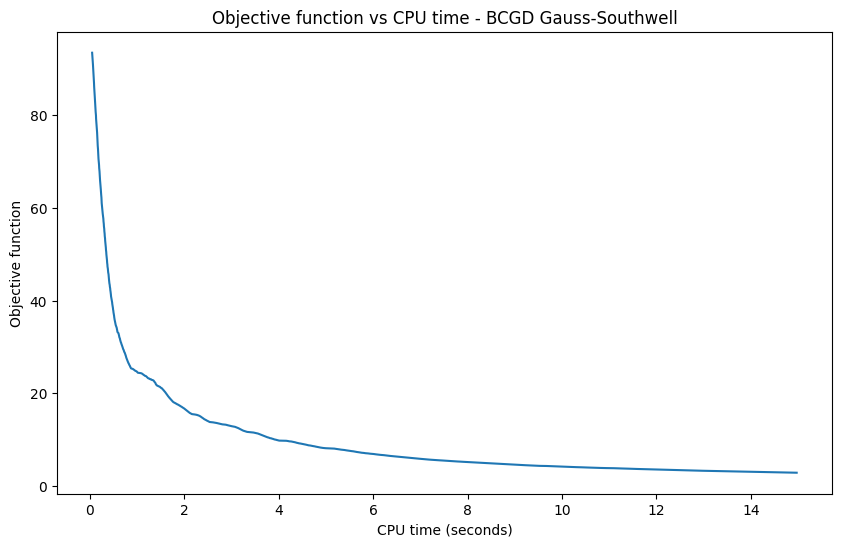

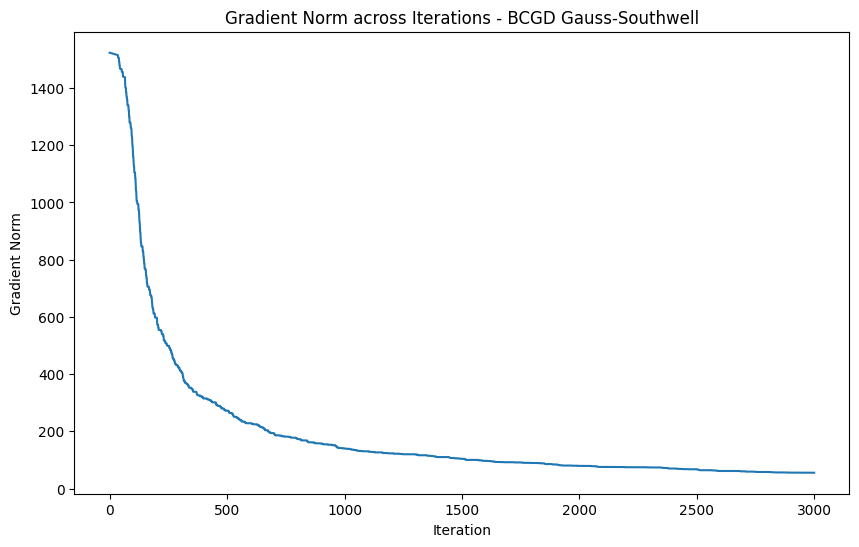

In [18]:
# Let's see how it performs
X_values_BCGD_GS, gradient_norms_BCGD_GS, times_BCGD_GS = Gauss_Southwell_final(X,A,labels,lr= LR, iterations= ITERATIONS)

losses_BCGD_GS = [cost_function(X_val, A, labels) for X_val in X_values_BCGD_GS]

plotting_GS(times_BCGD_GS, losses_BCGD_GS, gradient_norms_BCGD_GS)

## 11. Comparison between the models

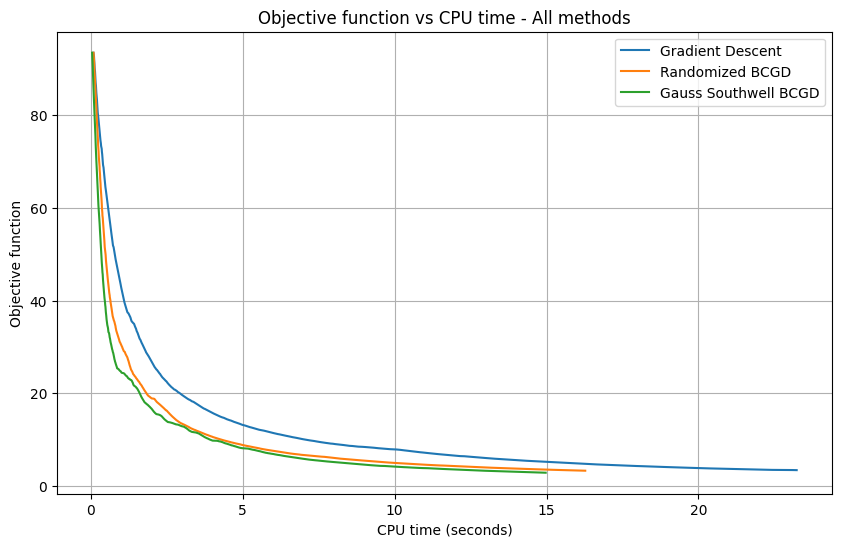

In [19]:
# Graph comparison of all three methods
plt.figure(figsize=(10, 6))
plt.plot(times_GD, losses_GD, label = 'Gradient Descent')
plt.plot(times_BCGD, losses_BCGD, label = 'Randomized BCGD')
plt.plot(times_BCGD_GS, losses_BCGD_GS, label = 'Gauss Southwell BCGD')
plt.xlabel('CPU time (seconds)')
plt.ylabel('Objective function')
plt.title('Objective function vs CPU time - All methods')
plt.grid(True)
plt.legend()
plt.show()

## 12. Real Dataset : Import, Exploration and Preparation

Alpaydin,E. and Kaynak,C.. (1998). 

Optical Recognition of Handwritten Digits.

UCI Machine Learning Repository. 

https://doi.org/10.24432/C50P49.

In [20]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 

# data (as pandas dataframes) 
X = optical_recognition_of_handwritten_digits.data.features 
y = optical_recognition_of_handwritten_digits.data.targets 

NUM_SAMPLES_ALL = X.shape[0]
NUM_FEATURES = X.shape[1]
NUM_LABELS = len(np.unique(y))

d = NUM_FEATURES
k = NUM_LABELS 


# Fit and transform the data
#X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

A = np.array(X)
labels = np.array(y)

# Split the data into training and test sets
A_train, A_test, labels_train, labels_test = train_test_split(A, labels, test_size=0.2, random_state=42)

# We will use the train split for learning
m = A_train.shape[0]

# Scale the data
scaler = StandardScaler()

# Fit and transform the training data
A_train = scaler.fit_transform(A_train)

# Transform the test data
A_test = scaler.transform(A_test)

labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

### Weight and bias matrix

In [21]:
weight_matrix = np.random.normal(0, 1, size = (d,k))
X = weight_matrix

E = np.random.normal(0,1 , size = (A_test.shape[0],k))

### Encoding labels

In [22]:
I = np.zeros((m,k))
for label_idx in range(k):

    I[:,label_idx] = np.eye(k)[labels_train.flatten()][:, label_idx]

I_b = I.T

### Hyperparameters

In [23]:
# EPSILON and ITERATIONS stay the same
LR = 1/lipschitz(A_train)


## 13. GD - Real Data

Execution time: 6.869486093521118 seconds


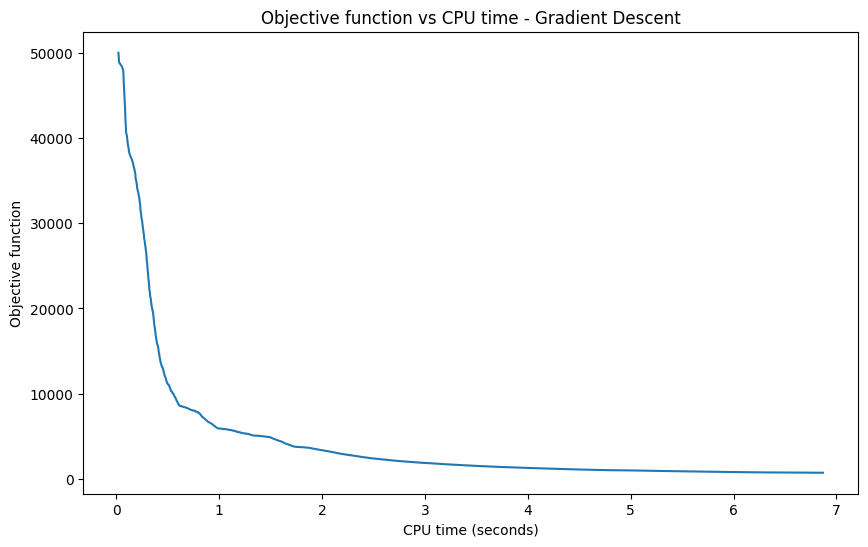

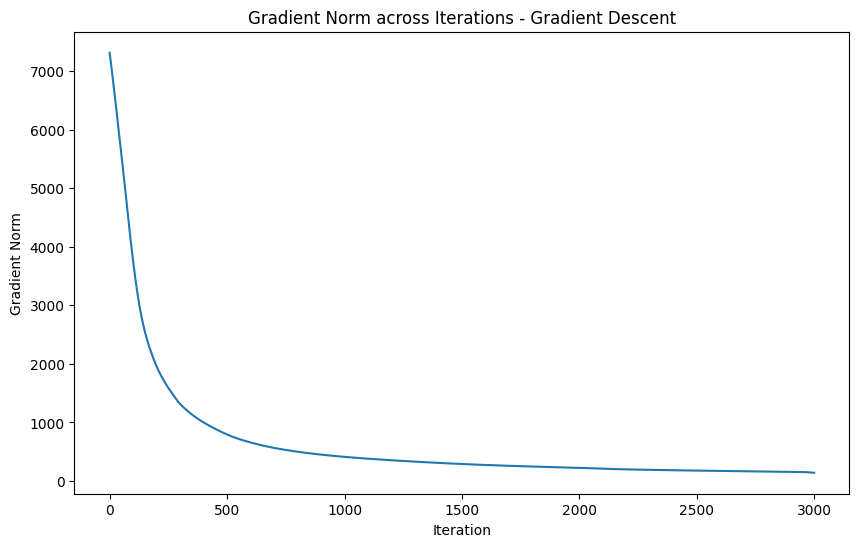

In [24]:
X_values_GD, gradient_norms_GD, times_GD = gradient_descent(X,A_train,labels_train, lr= LR, iterations= ITERATIONS)

losses_GD = [cost_function(X_val, A_train, labels_train) for X_val in X_values_GD]

plotting_GD(times_GD,losses_GD,gradient_norms_GD)

## 14. BCGD Randomized - Real Data

In [25]:
# Generate the list of random choices of classes beforehand 
random_choices = []
for i in range(ITERATIONS): 
    random_choices.append(random.randint(0,k-1))

Execution time: 4.250710725784302 seconds


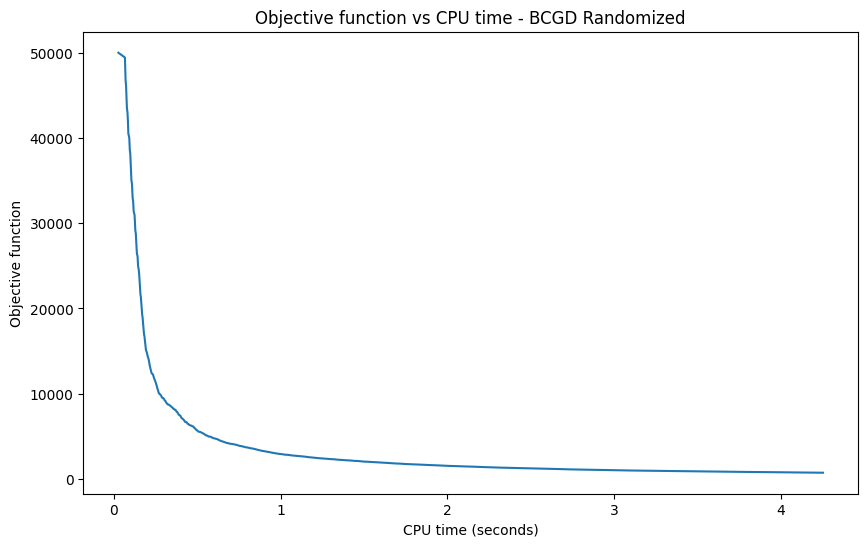

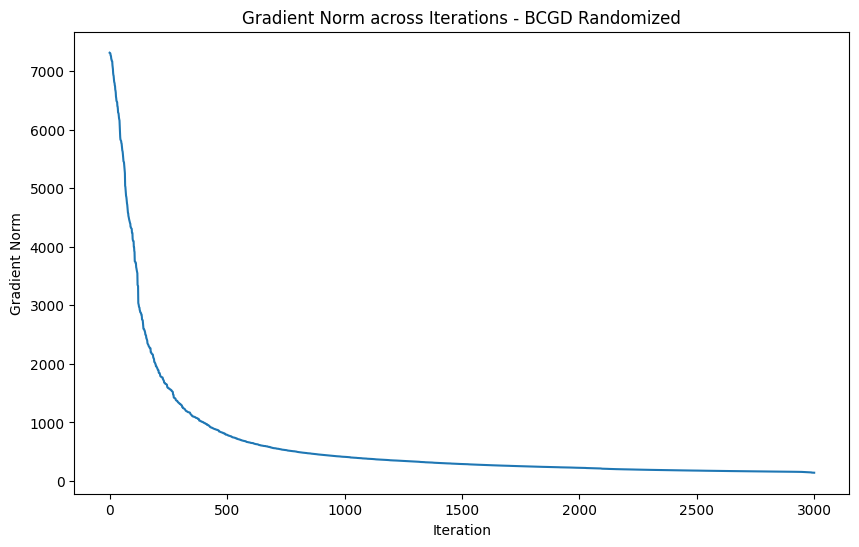

In [26]:
X_values_BCGD, gradient_norms_BCGD, times_BCGD = BCGD_randomized(X,A_train, labels_train,lr= LR, iterations=ITERATIONS)
losses_BCGD = [cost_function(X_val, A_train, labels_train) for X_val in X_values_BCGD]

plotting_RAND(times_BCGD, losses_BCGD, gradient_norms_BCGD)

## 15. BCGD Gauss-Southwell - Real Data

Execution time: 4.933625936508179 seconds


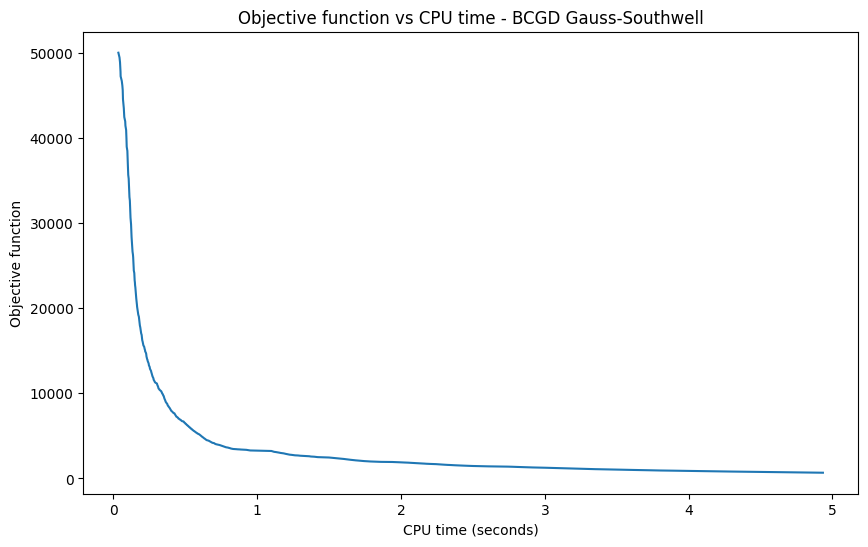

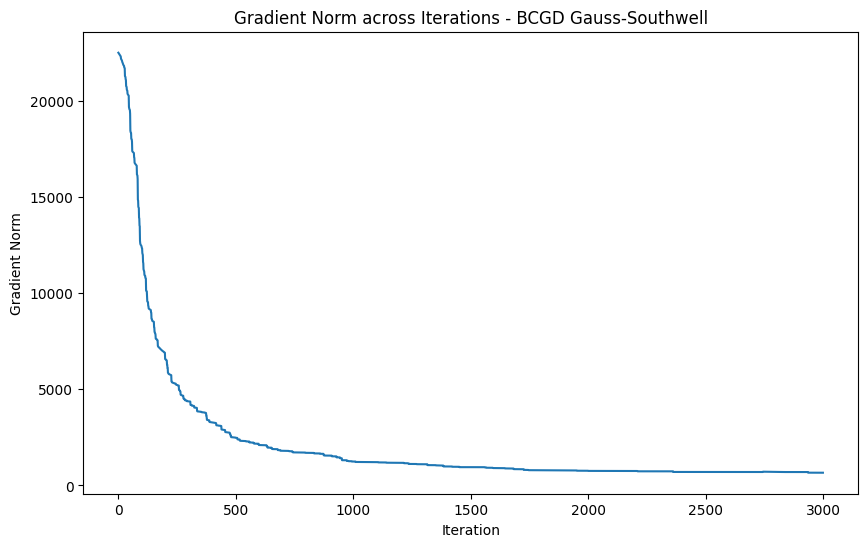

In [27]:
X_values_BCGD_GS, gradient_norms_BCGD_GS, times_BCGD_GS = Gauss_Southwell_final(X,A_train,labels_train,lr= LR, iterations= ITERATIONS)

losses_BCGD_GS = [cost_function(X_val, A_train, labels_train) for X_val in X_values_BCGD_GS]

plotting_GS(times_BCGD_GS, losses_BCGD_GS, gradient_norms_BCGD_GS)

## 16. Accuracy Check on the test set

In [28]:
# We use softmax to calculate the probabilities of being in one of the k classes
def softmax(matrix):
    # Subtract max for numerical stability
    shift_matrix = matrix - np.max(matrix, axis=1, keepdims=True)
    exps = np.exp(shift_matrix)
    softmax_matrix = exps / np.sum(exps, axis=1, keepdims=True)
    return softmax_matrix

In [29]:
def accuracy(feature_matrix, data, labels):

    matrix = (data @ feature_matrix) + E

    softmax_results = softmax(matrix)
    
    # Pick the index (= class) with the largest probability for each sample
    labels_predicted = np.argmax(softmax_results, axis=1)

    same_values = (labels_predicted == labels.flatten())

    num_same_values = np.sum(same_values)

    accuracy = (num_same_values / labels.shape[0]) * 100

    return accuracy

In [30]:
accuracy_GD = accuracy(X_values_GD[-1], A_test, labels_test)
accuracy_BCGD = accuracy(X_values_BCGD[-1], A_test, labels_test)
accuracy_BCGD_GS = accuracy(X_values_BCGD_GS[-1], A_test, labels_test)

names = ['Gradient Descent Normal', 'Block Gradient Descent, Randomized', 'Block Gradient Descent, Gauss-Southwell Rule']
accuracies = [accuracy_GD, accuracy_BCGD, accuracy_BCGD_GS]
for idx,_ in enumerate(accuracies):

    print("Accuracy of {} is {} percent".format(names[idx], accuracies[idx]))

Accuracy of Gradient Descent Normal is 92.88256227758008 percent
Accuracy of Block Gradient Descent, Randomized is 92.97153024911033 percent
Accuracy of Block Gradient Descent, Gauss-Southwell Rule is 93.14946619217082 percent


## 17. Graph Comparison between the algorithms on real data

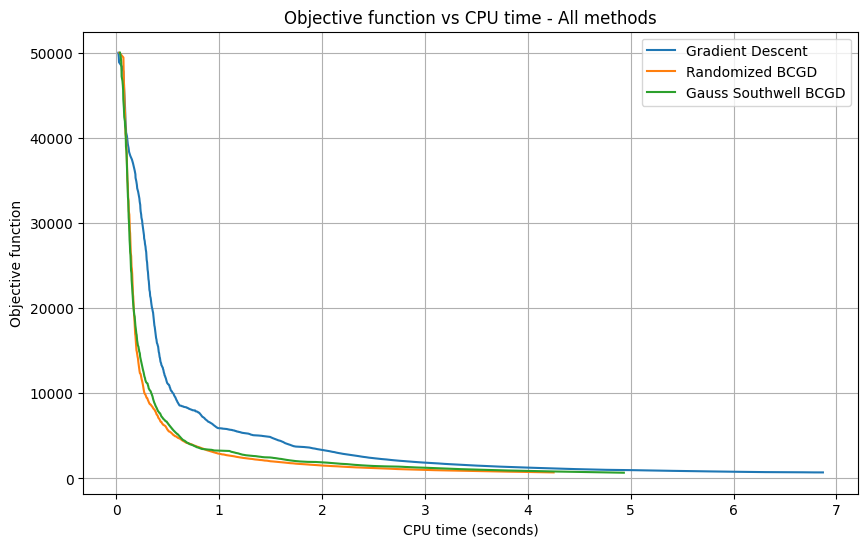

In [31]:
# Graph comparison of all three methods
plt.figure(figsize=(10, 6))
plt.plot(times_GD, losses_GD, label = 'Gradient Descent')
plt.plot(times_BCGD, losses_BCGD, label = 'Randomized BCGD')
plt.plot(times_BCGD_GS, losses_BCGD_GS, label = 'Gauss Southwell BCGD')
plt.xlabel('CPU time (seconds)')
plt.ylabel('Objective function')
plt.title('Objective function vs CPU time - All methods')
plt.grid(True)
plt.legend()
plt.show()